In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from autophasemap import compute_elastic_kmeans

In [3]:
import abc 
from scipy.signal import savgol_filter

class BaseDataSet(abc.ABC):
    def __init__(self, n_domain):
        self.n_domain = n_domain 

    @abc.abstractmethod
    def generate(self):
        """Generate the dataset.

        Add the functional data into a list self.F.
        """

    def _smoothen(self, f, **kwargs):
        """Compute a Savitsky-Golay filtering of the data

        Inputs:
        =======
            f : function values at the discrete sample along the domain
        
        returns:
        ========
            f_hat : Smoothened function values
        """
        f_hat = savgol_filter(f, **kwargs)
        
        return f_hat
    
    def l2norm(self, t, f):
        """Compute L2-norm of functions
        
        Inputs:
        =======
            t : numpy array of shape (n_domain, )
                the discrete sample along the domain
            f : numpy array of shape (n_domain, )
                function values at the discrete sample along the domain
        
        returns:
        ========
            norm : float 
                Norm of the function
        """
        norm = np.sqrt(np.trapz(f**2, t))
        
        return norm

In [4]:
# create synthetic data
class DataSet(BaseDataSet):
    def __init__(self, C, P, n_domain = 100):
        super().__init__(n_domain=n_domain)
        self.t = np.linspace(0,1, num=self.n_domain)
        self.N = C.shape[0]
        self.P = P
        self.C = C
        self.n_clusters = 3
        
    def g(self, t, p):
        out = np.zeros(self.t.shape)
        for i in range(1,p+1):
            zi = np.random.normal(1, 0.1)
            mean = (2*i-1)/(2*p)
            std = 1/(3*p)
            out += zi*self.phi(t, mean, std)

        return out
    
    def phi(self, t, mu, sigma):
        factor = 1/(2*(sigma**2))
        return np.exp(-factor*(t-mu)**2)
    
    def gamma(self):
        a = np.random.uniform(-3, 3)
        if a==0:
            gam = self.t
        else:
            gam = (np.exp(a*self.t)-1)/(np.exp(a)-1)
        return gam
    
    def generate(self):
        self.F = [self.g(self.gamma(), self.P[i]) for i in range(self.N)]

        return

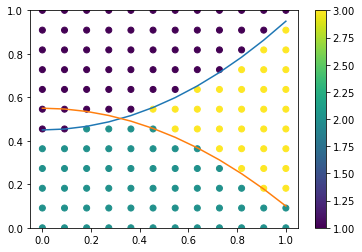

In [5]:
n_grid = 12
x = np.linspace(0,1, n_grid)
y = np.linspace(0,1, n_grid)
X,Y = np.meshgrid(x,y)
points = np.vstack([X.ravel(), Y.ravel()]).T
phase1 = lambda x : 0.5*(x)**2+0.45
phase2 = lambda x : -0.45*(x)**2+0.55

# plot the dummy phase map
def get_label(c):
    if c[1]-phase1(c[0])>0:
        label = 1
    elif c[1]-phase2(c[0])<0:
        label = 2
    else:
        label = 3
        
    return label

labels = [get_label(p) for p in points]

fig, ax = plt.subplots()
sc = ax.scatter(points[:,0], points[:,1], c=labels)
ax.plot(x, phase1(y))
ax.plot(x, phase2(y))
ax.set_ylim([0,1])
cbar = plt.colorbar(sc)
plt.show()

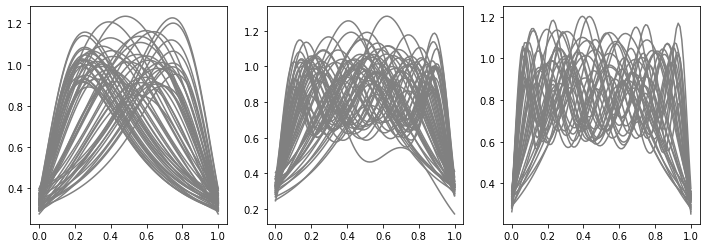

In [6]:
n_domain = 200

data = DataSet(points, labels)
data.generate()
fig, axs = plt.subplots(1, 3, figsize=(4*3, 4))
for i in range(data.N):
    axs[data.P[i]-1].plot(data.t, data.F[i], color='grey')
plt.show()

In [7]:
import time, datetime 
from collections import namedtuple
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist 
from autophasemap import assign_clusters

def compute_euclidean_kmeans(data, n_clusters, max_iter=100, verbose=1, smoothen=True):
    """Compute Euclidean kmeans result for phasemapping. 
    
    This function computes a Euclidean k-means based approximation of the template functions.
    
    Parameters:
    ===========
    data : Data class object 
        (see examples)
    n_clusters : int
        Number of template functions
    max_iter : int, default 100
        Maximum number of iterations to perform
    verbose : int, [1,2,3]
        Flag to print output 
    smoothen : Boolean (default, True)
        Boolean variable to use Diffusion based assignment
        
    Returns:
    ========
    res : namedtuple
        templates : Learned template functions as a list of numpy arrays
        gam_ik : Warping functions 
            numpy array of shape (n_samples, n_templates)
        qik_gam : SRSF functions of the original data. 
            Numpy array of shape (n_samples, n_templates)
        fik_gam : Temaplte-algined original functional data. 
            Numpy array of shape (n_samples, n_templates, n_domain)
        delta_n : Array of labels assigning each data point to a template
            List of integer labels of shape (n_sample, )
        d_amplitude : Amplitude distance of each data point to a template
            Numpy array of shape (n_sample, n_templates)
        dist : Diffused version of `d_amplitude'
            Numpy array of shape (n_sample, n_templates)     
        error: Final error at the end of the execution (float)

    Notes:
    ======
    Some of the output varaibles are redundant but are kept to keep the consistency
    with `compute_elastic_kmeans` function
                                                                                                
    """
    res = namedtuple("res", "templates gam_ik qik_gam fik_gam delta_n dist d_amplitude error")
    start = time.time()
    kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init=10, max_iter=max_iter, verbose=verbose)
    n_samples = len(data.F)
    X = np.asarray(data.F)
    kmeans.fit(X)
    templates = kmeans.cluster_centers_ 
    gam_ik = np.ones((n_samples, n_clusters))
    qik_gam = np.ones((n_samples, n_clusters)) 
    fik_gam = np.tile(X.reshape(len(data.F), 1, data.n_domain), [1,n_clusters,1])
    d_amplitude = cdist(X, templates) 
    dist, delta_n = assign_clusters(data, d_amplitude, smoothen=smoothen) 
    error = kmeans.inertia_  

    end = time.time()
    time_str =  str(datetime.timedelta(seconds=end-start))   
    print('Error : %2.4f and took %s'%(error, time_str))
        
    return res(templates, gam_ik, qik_gam, fik_gam, delta_n, dist, d_amplitude, error)

In [11]:
def plot(data, out):
    fig, axs = plt.subplots(1,4, figsize=(4*4, 4))
    for k, ax in enumerate(axs):
        if k==3:
            ax.scatter(data.C[:,0], data.C[:,1], c=out.delta_n)
            continue
        Mk = np.argwhere(out.delta_n==k).squeeze()
        for i in Mk:
            ax.plot(data.t, out.fik_gam[i,k,:], color='grey')
        
        ax.plot(data.t, out.templates[k], lw=3.0, color='tab:red') 
        ax.axis('off')

(0:00:02.621656)	Iteration : 0	Error : 0.8887
(0:00:16.017643)	Iteration : 10	Error : 0.0137
(0:00:28.482803)	Iteration : 20	Error : 0.1057
(0:00:41.016959)	Iteration : 30	Error : 0.0669
(0:00:53.572037)	Iteration : 40	Error : 0.0847
(0:01:06.380992)	Iteration : 50	Error : 0.0188
(0:01:19.240664)	Iteration : 60	Error : 0.0470
(0:01:31.823311)	Iteration : 70	Error : 0.0209
(0:01:44.210311)	Iteration : 80	Error : 0.0522
(0:01:56.661965)	Iteration : 90	Error : 0.0466
Total iterations 99	Error : 0.0554 and took 0:02:07.755692


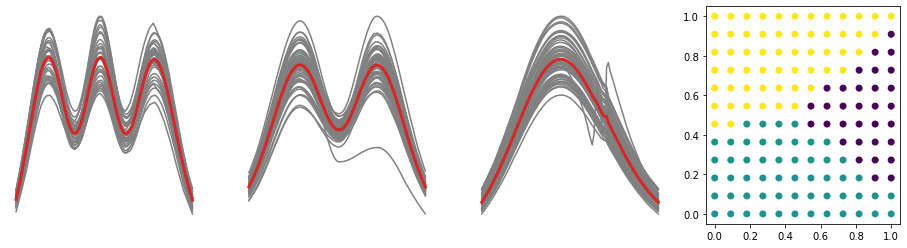

In [9]:
N_CLUSTERS = 3
MAX_ITER = 100
VERBOSE = 3

out_elastic = compute_elastic_kmeans(data, N_CLUSTERS, 
    max_iter=MAX_ITER, 
    verbose=VERBOSE, 
    smoothen=True
    )
plot(data, out_elastic)
plt.savefig('gaussians_autophasemap.png', dpi=600)

Error : 255.8625 and took 0:00:00.023583


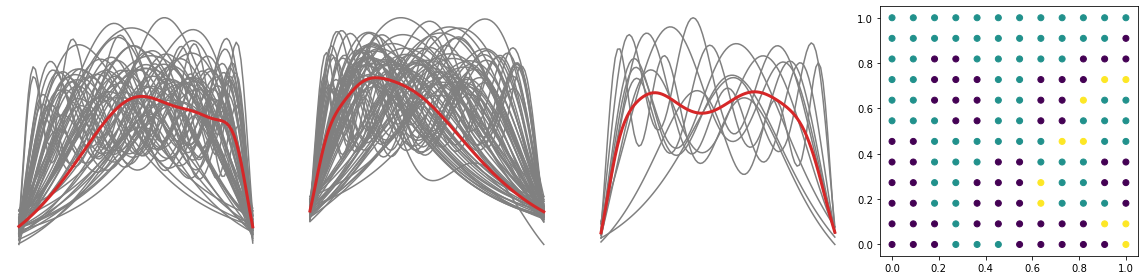

In [12]:
N_CLUSTERS = 3
MAX_ITER = 300
VERBOSE = 0

out_euclidean = compute_euclidean_kmeans(data, N_CLUSTERS, 
    max_iter=MAX_ITER, 
    verbose=VERBOSE, 
    smoothen=True
    )
plot(data, out_euclidean)
plt.tight_layout()
plt.savefig('gaussians_baselines.png', dpi=600)